In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

def dssp_to_strand(dssp_lines):
    """
    Convert DSSP strings into a binary beta strand matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = strand ('E', 'B'), 0 = non-strand.
    """
    strand_codes = {'E', 'B'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    strandicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        strandicity[i, :] = [1 if c in strand_codes else 0 for c in line]
    
    return strandicity

# paths
output_path = './plots_AAQAA3/'
prod_name = 'AAQAA3'
path = '../REST2/AAQAA3/PROD_REST2/'

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


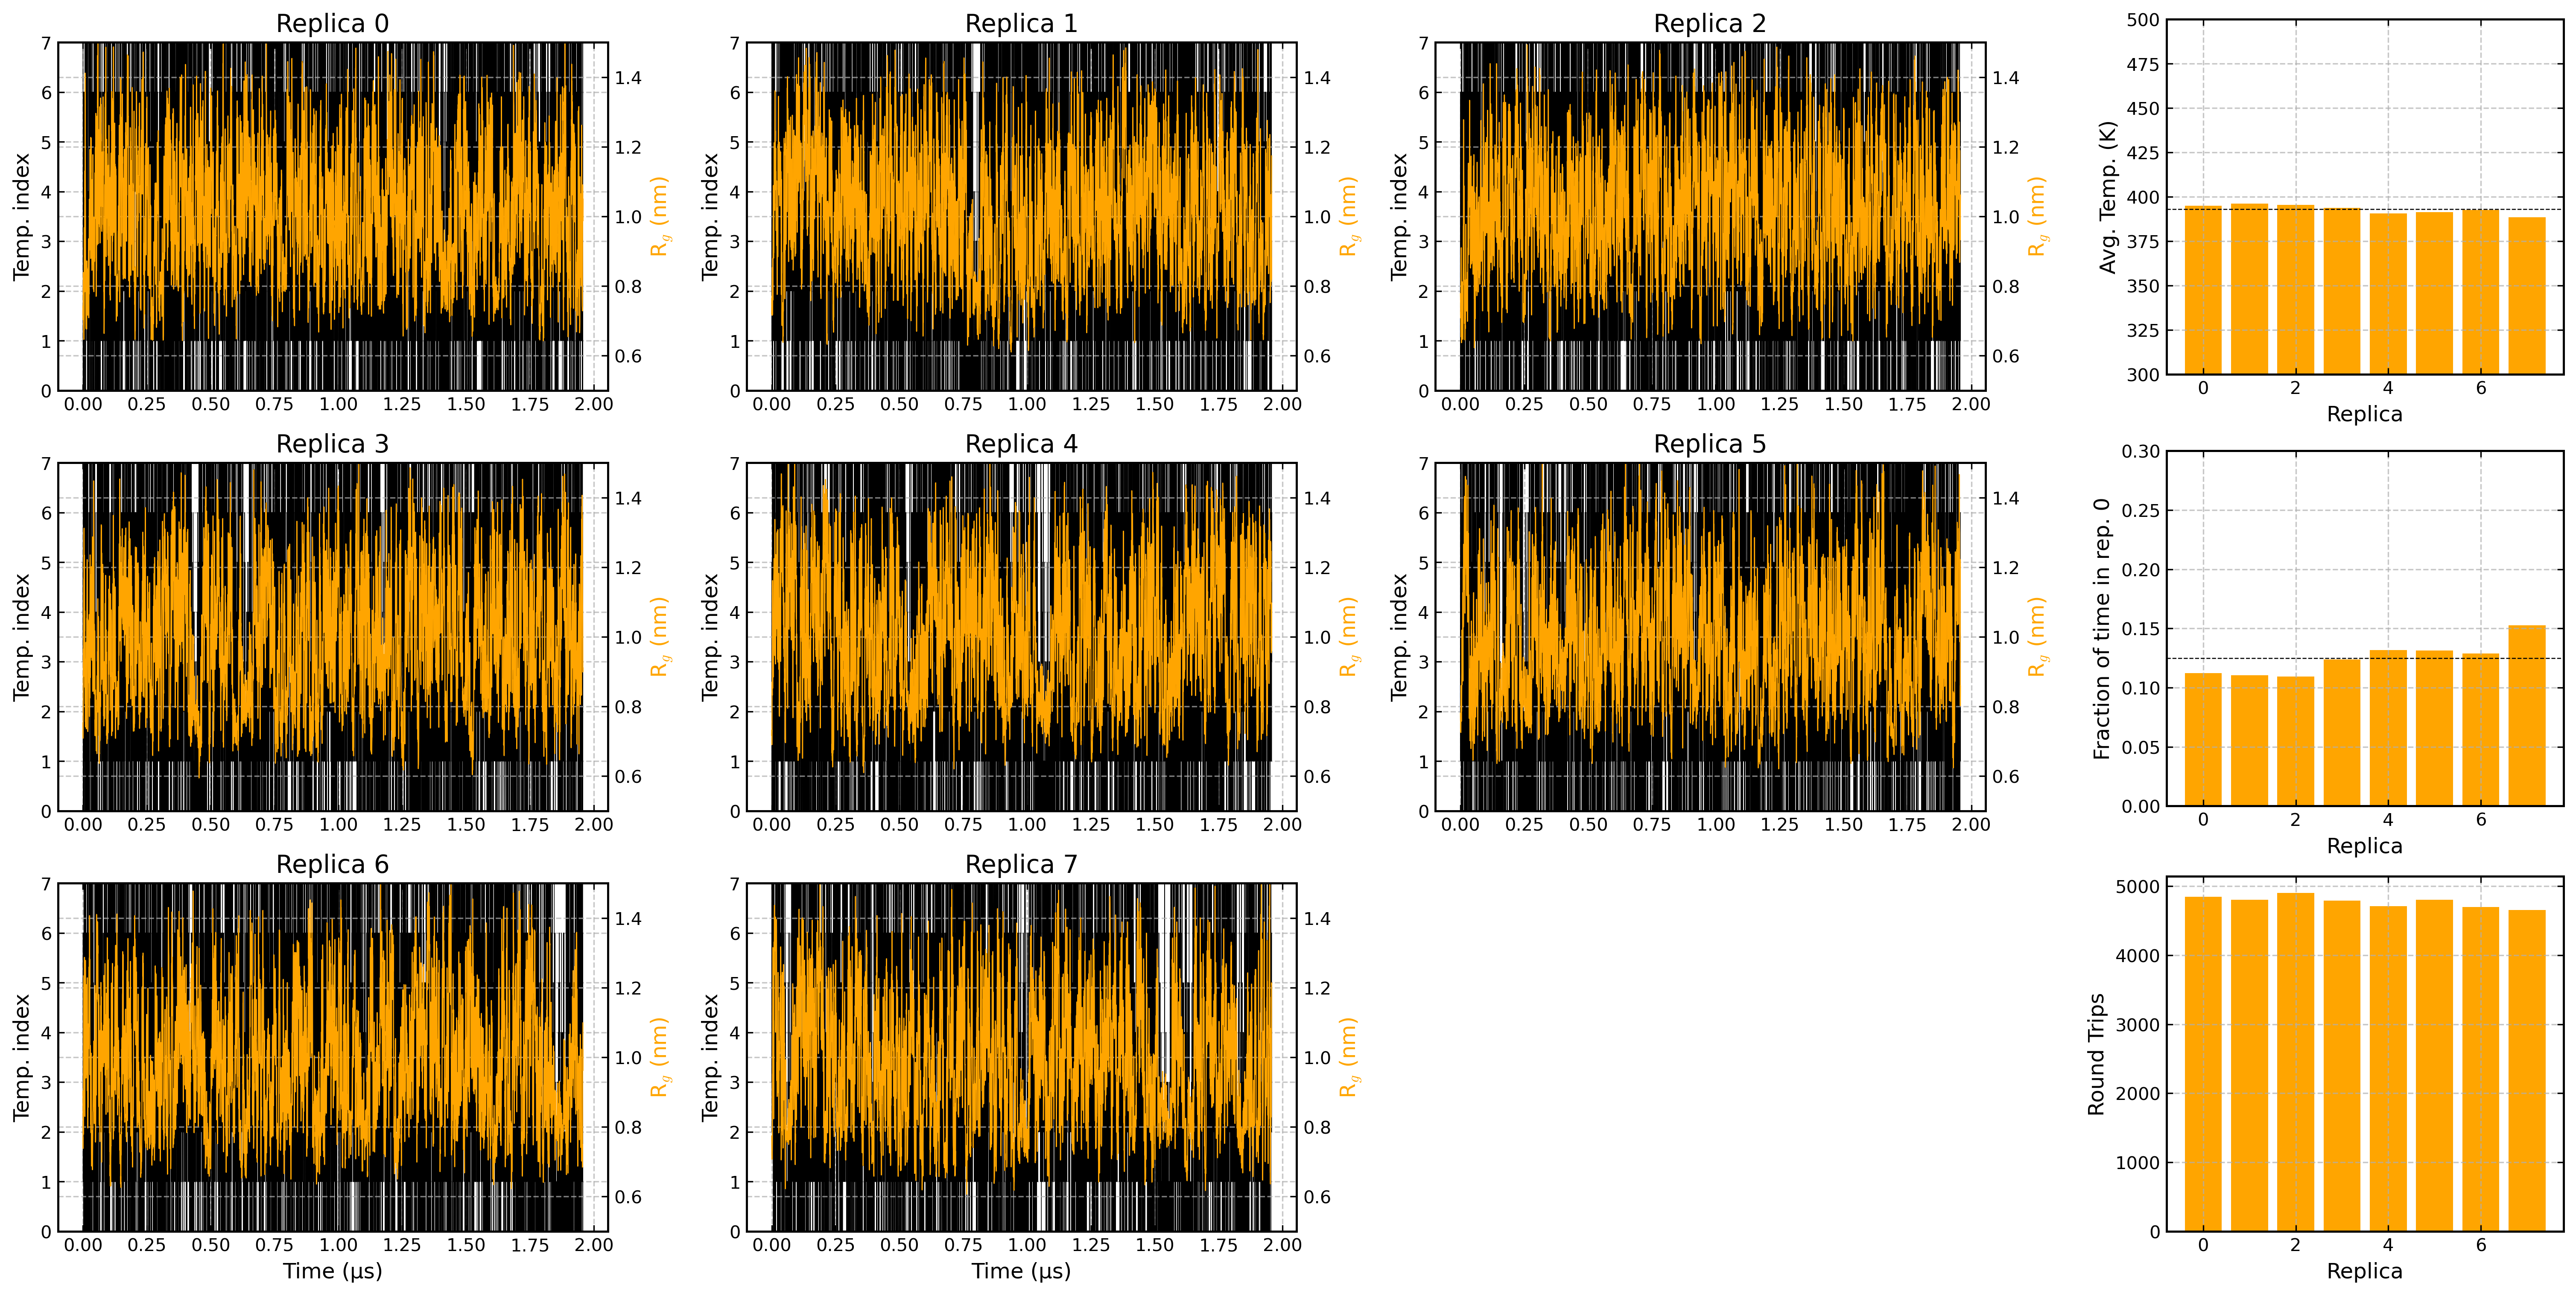

In [2]:

import matplotlib.gridspec as gridspec

# ================================================================
# Load data
# ================================================================
temp_data_full = np.loadtxt(path + 'DEMUX/replica_temp.xvg')
temp_data = temp_data_full[::100]          # downsample for plotting
nreplica = temp_data.shape[1] - 1

# Load Rg demultiplexed data
def load_rg(rep):
    d = np.loadtxt(path + f'DEMUX/CVS_DATA.{rep}')[::10]
    return d[:,0] * 40 / 1e6, d[:,1]       # convert ns→µs


# ================================================================
# Compute replica stats
# ================================================================
lambdas = np.array([1.000,0.930,0.864,0.803,0.747,0.694,0.645,0.600])
temps = 300 / lambdas
replicas = np.arange(nreplica)

# Average temperature per replica
temp_idx = temp_data_full[:,1:].astype(int)
mapped = temps[temp_idx]
avg_temp = mapped.mean(axis=0)

# Fraction of time in T0
is_T0 = (temp_data_full[:,1:] == 0).astype(int)
avg_time_frac_rep0 = is_T0.mean(axis=0)

# Round trips
states = np.zeros((temp_data_full.shape[0], nreplica))
up = np.zeros(nreplica)
down = np.zeros(nreplica)

for j in range(1, temp_data_full.shape[0]):
    for k in range(1, nreplica + 1):
        cur = int(temp_data_full[j, k])
        prev = states[j-1, k-1]

        if cur == 0:
            states[j, k-1] = -1
            if prev == 1:
                down[k-1] += 1
        elif cur == nreplica-1:
            states[j, k-1] = 1
            if prev == -1:
                up[k-1] += 1
        else:
            states[j, k-1] = prev

roundtrips = down


# ================================================================
# Determine replica grid shape
# ================================================================
nrows = int(np.ceil(np.sqrt(nreplica)))
ncols = nrows


# ================================================================
# Create figure with LEFT replica-grid and RIGHT barplots
# ================================================================
fig = plt.figure(figsize=(20, 10), constrained_layout=True)

gs = gridspec.GridSpec(
    nrows, 2,
    figure=fig,
    width_ratios=[4, 1],
    wspace=0.25
)


# ---------------------------------------------------------------
# LEFT side: Temp/Rg plots arranged in (nrows × ncols)
# ---------------------------------------------------------------
gs_left = gridspec.GridSpecFromSubplotSpec(
    nrows, ncols,
    subplot_spec=gs[:, 0],
    wspace=0.15,
    hspace=0.30
)

time_temp = temp_data[:,0] / 1e6

for i in range(nreplica):

    ax = fig.add_subplot(gs_left[i])

    # Temperature (black)
    ax.plot(time_temp, temp_data[:,i+1], color="black", lw=0.3, rasterized=True)
    ax.set_ylim(0, nreplica - 1)
    ax.set_ylabel("Temp. index")

    # RG (orange)
    t_rg, rg = load_rg(i)
    ax2 = ax.twinx()
    ax2.plot(t_rg, rg, color="#FFA500", lw=0.6, rasterized = True)
    ax2.set_ylim(0.5, 1.5)
    ax2.set_ylabel("R$_g$ (nm)", color="#FFA500")

    ax.set_title(f"Replica {i}")

    if i // ncols == nrows - 1:
        ax.set_xlabel("Time (µs)")


# ---------------------------------------------------------------
# RIGHT side: Barplots stacked vertically (one per row)
# Row 0 → Avg Temp
# Row 1 → Time at T0
# Row 2 → Round trips
# ---------------------------------------------------------------

# ---- Barplot row 1: Avg Temp ----
ax_b1 = fig.add_subplot(gs[0, 1])
ax_b1.bar(replicas, avg_temp, color="#FFA500")
ax_b1.axhline(np.mean(temps), linestyle='dashed', color='black', lw=0.6)
ax_b1.set_ylabel("Avg. Temp. (K)")
ax_b1.set_ylim(300, 500)
ax_b1.set_xlabel("Replica")

# ---- Barplot row 2: Time at T0 ----
if nrows > 1:
    ax_b2 = fig.add_subplot(gs[1, 1])
    ax_b2.bar(replicas, avg_time_frac_rep0, color="#FFA500")
    ax_b2.axhline(1/nreplica, linestyle='dashed', color='black', lw=0.6)
    ax_b2.set_ylabel("Fraction of time in rep. 0")
    ax_b2.set_ylim(0, 0.3)
    ax_b2.set_xlabel("Replica")

# ---- Barplot row 3: Round trips ----
if nrows > 2:
    ax_b3 = fig.add_subplot(gs[2, 1])
    ax_b3.bar(replicas, roundtrips, color="#FFA500")
    ax_b3.set_ylabel("Round Trips")
    ax_b3.set_xlabel("Replica")


# ================================================================
# Save figure
# ================================================================
plt.savefig(output_path + f"{prod_name}_MASTER_TEMP_RG_STATS.pdf", dpi=300)



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


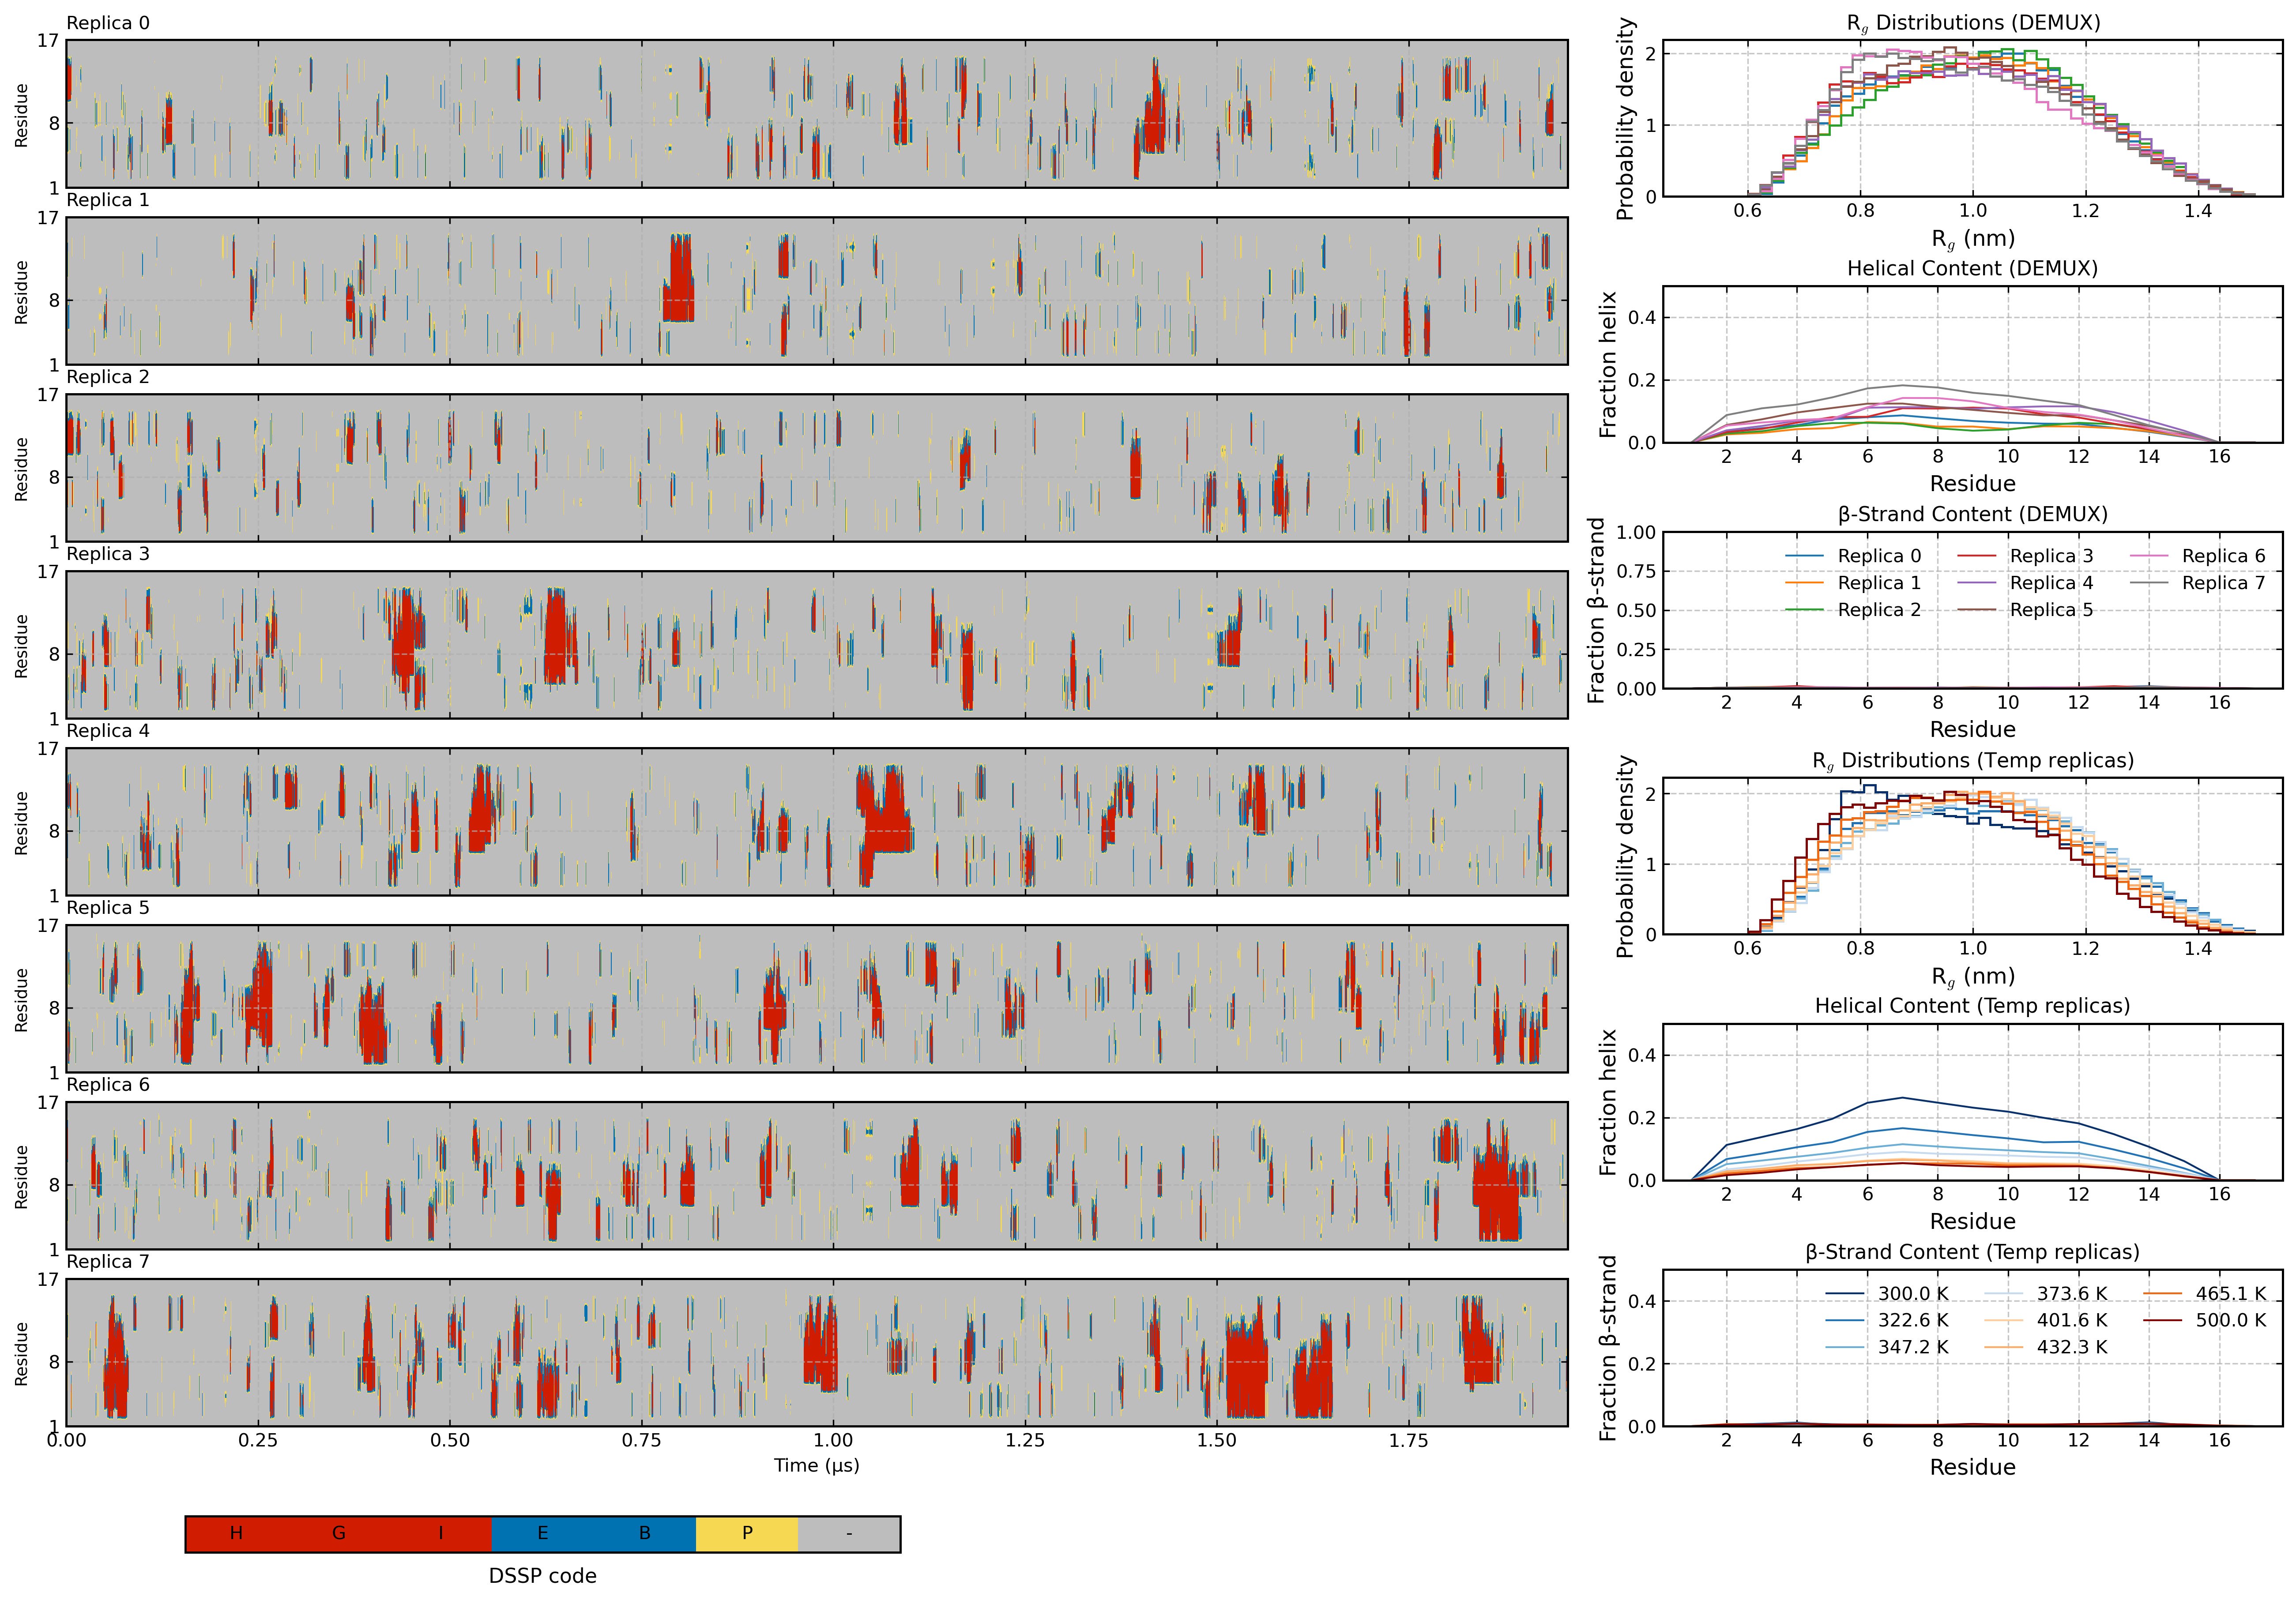

In [3]:

from matplotlib.colors import ListedColormap

# -------------------------------------------------------------------
# Load once
# -------------------------------------------------------------------
nreplica = 8
bins = np.linspace(0.5, 1.5, 50)
colors_temp = ["#08306B", "#2171B5", "#6BAED6", "#C6DBEF",
               "#FDD0A2", "#FDAE6B", "#F16913", "#7F0000"]

lambdas = np.array([1.000,0.930,0.864,0.803,0.747,0.694,0.645,0.600])
temps = np.round(300/lambdas,1)

# -------------------------------------------------------------------
# DSSP color map
# -------------------------------------------------------------------
dssp_codes = ["H", "G", "I", "E", "B", "P","-"]
colors = [
    "#D01C00", "#D01C00", "#D01C00",
    "#0072B2", "#0072B2",
    "#F6D853",
    "#BDBDBD"
]
cmap = ListedColormap(colors)
dssp_mapping = {'H':0,'G':1,'I':2,'E':3,'B':4,'P':5,'-':6}

# -------------------------------------------------------------------
# FIGURE LAYOUT
# -------------------------------------------------------------------
fig_height = nreplica * 1.2 + 4
fig = plt.figure(figsize=(18, fig_height))

# Left column (DSSP): wide
gs_left = gridspec.GridSpec(
    nreplica, 1,
    left=0.05, right=0.68,
    hspace=0.20
)

# Right column (stacked summary plots): narrow
gs_right = gridspec.GridSpec(
    6, 1,
    left=0.72, right=0.98,
    hspace=0.57
)


# -------------------------------------------------------------------
# LEFT COLUMN — DSSP HEATMAP (rows = replicas)
# -------------------------------------------------------------------
axes_dssp = []

for i in range(nreplica):

    ax = fig.add_subplot(gs_left[i])
    axes_dssp.append(ax)

    # Load DSSP
    with open(path + f'DEMUX/dssp_{i}.dat') as f:
        dssp_lines = [line.strip() for line in f]

    n_frames = len(dssp_lines)
    n_res = len(dssp_lines[0])

    dssp_array = np.array([[dssp_mapping.get(c, 6) for c in line] for line in dssp_lines]).T

    total_time_us = n_frames * 40 / 1e6

    im = ax.imshow(dssp_array, aspect='auto', origin='lower', cmap=cmap,
                   extent=[0, total_time_us, 1, n_res], rasterized=True)

    ax.set_title(f"Replica {i}", fontsize=10, loc="left")
    ax.set_ylabel("Residue", fontsize=9)
    ax.set_yticks([1, n_res//2, n_res])
    ax.set_ylim(1, n_res)

    if i < nreplica - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Time (µs)", fontsize=10)


# Add colorbar under left column
cbar_ax = fig.add_axes([0.10, 0.04, 0.30, 0.02])
cb = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.ax.tick_params(length=0)
cb.set_ticks([])

for idx, label in enumerate(dssp_codes):
    cb.ax.text((idx+0.5)/len(colors), 0.5, label,
               ha='center', va='center', fontsize=10, color='black',
               transform=cb.ax.transAxes)

cb.set_label("DSSP code", fontsize=11, labelpad=8)



# -------------------------------------------------------------------
# RIGHT COLUMN PLOTS — perfectly stacked
# -------------------------------------------------------------------

# 1. Rg distributions (DEMUX)
ax1 = fig.add_subplot(gs_right[0])
for i in range(nreplica):
    data = np.loadtxt(path+f'DEMUX/CVS_DATA.{i}')
    ax1.hist(data[:,1], bins=bins, density=True, histtype='step',
             linewidth=1.2, label=f'Replica {i}')
ax1.set_title("R$_g$ Distributions (DEMUX)", fontsize=11)
ax1.set_xlabel("R$_g$ (nm)")
ax1.set_ylabel("Probability density")


# 2. Helicity (DEMUX)
ax2 = fig.add_subplot(gs_right[1])
for i in range(nreplica):
    with open(path+f'DEMUX/dssp_{i}.dat') as f:
        dssp_lines = np.array([l.strip() for l in f])
    H = np.mean(dssp_to_helicity(dssp_lines), axis=0)
    ax2.plot(np.arange(1,len(H)+1), H, linewidth=1., label=f'Replica {i}')
ax2.set_ylim(0,0.5)
ax2.set_title("Helical Content (DEMUX)", fontsize=11)
ax2.set_xlabel("Residue")
ax2.set_ylabel("Fraction helix")


# 3. Beta strand (DEMUX)
ax3 = fig.add_subplot(gs_right[2])
for i in range(nreplica):
    with open(path+f'DEMUX/dssp_{i}.dat') as f:
        dssp_lines = np.array([l.strip() for l in f][::10])
    S = np.mean(dssp_to_strand(dssp_lines), axis=0)
    ax3.plot(np.arange(1,len(S)+1), S, linewidth=1., label=f'Replica {i}')
ax3.set_ylim(0,1)
ax3.set_title("β-Strand Content (DEMUX)", fontsize=11)
ax3.set_xlabel("Residue")
ax3.set_ylabel("Fraction β-strand")
ax3.legend(ncol=3)


# 4. Rg (Temperature replicas)
ax4 = fig.add_subplot(gs_right[3])
for i in range(nreplica):
    data = np.loadtxt(path+f'dir{i}/CVS_DATA')
    ax4.hist(data[:,1], bins=bins, density=True, histtype='step',
             linewidth=1.2, color=colors_temp[i], label=f'{temps[i]} K')
ax4.set_title("R$_g$ Distributions (Temp replicas)", fontsize=11)
ax4.set_xlabel("R$_g$ (nm)")
ax4.set_ylabel("Probability density")



# 5. Helicity (Temperature replicas)
ax5 = fig.add_subplot(gs_right[4])
for i in range(nreplica):
    with open(path+f'dir{i}/dssp.dat') as f:
        dssp_lines = np.array([l.strip() for l in f][::10])
    H = np.mean(dssp_to_helicity(dssp_lines), axis=0)
    ax5.plot(np.arange(1,len(H)+1), H, linewidth=1., color=colors_temp[i], label=f'{temps[i]} K')
ax5.set_ylim(0,0.5)
ax5.set_title("Helical Content (Temp replicas)", fontsize=11)
ax5.set_xlabel("Residue")
ax5.set_ylabel("Fraction helix")


# 6. Beta strand (Temperature replicas)
ax6 = fig.add_subplot(gs_right[5])
for i in range(nreplica):
    with open(path+f'dir{i}/dssp.dat') as f:
        dssp_lines = np.array([l.strip() for l in f][::10])
    S = np.mean(dssp_to_strand(dssp_lines), axis=0)
    ax6.plot(np.arange(1,len(S)+1), S, linewidth=1., color=colors_temp[i], label=f'{temps[i]} K')
ax6.set_ylim(0,0.5)
ax6.set_title("β-Strand Content (Temp replicas)", fontsize=11)
ax6.set_xlabel("Residue")
ax6.set_ylabel("Fraction β-strand")
ax6.legend(ncol=3)



# -------------------------------------------------------------------
# SAVE
# -------------------------------------------------------------------
plt.savefig(output_path + f"{prod_name}_COMBINED_DSSP_AND_REPLICA_METRICS.pdf",
            dpi=300, bbox_inches='tight')
